
# Probability Calibration curves


When performing classification one often wants to predict not only the class
label, but also the associated probability. This probability gives some
kind of confidence on the prediction. This example demonstrates how to display
how well calibrated the predicted probabilities are and how to calibrate an
uncalibrated classifier.

The experiment is performed on an artificial dataset for binary classification
with 100,000 samples (1,000 of them are used for model fitting) with 20
features. Of the 20 features, only 2 are informative and 10 are redundant. The
first figure shows the estimated probabilities obtained with logistic
regression, Gaussian naive Bayes, and Gaussian naive Bayes with both isotonic
calibration and sigmoid calibration. The calibration performance is evaluated
with Brier score, reported in the legend (the smaller the better). One can
observe here that logistic regression is well calibrated while raw Gaussian
naive Bayes performs very badly. This is because of the redundant features
which violate the assumption of feature-independence and result in an overly
confident classifier, which is indicated by the typical transposed-sigmoid
curve.

Calibration of the probabilities of Gaussian naive Bayes with isotonic
regression can fix this issue as can be seen from the nearly diagonal
calibration curve. Sigmoid calibration also improves the brier score slightly,
albeit not as strongly as the non-parametric isotonic regression. This can be
attributed to the fact that we have plenty of calibration data such that the
greater flexibility of the non-parametric model can be exploited.

The second figure shows the calibration curve of a linear support-vector
classifier (LinearSVC). LinearSVC shows the opposite behavior as Gaussian
naive Bayes: the calibration curve has a sigmoid curve, which is typical for
an under-confident classifier. In the case of LinearSVC, this is caused by the
margin property of the hinge loss, which lets the model focus on hard samples
that are close to the decision boundary (the support vectors).

Both kinds of calibration can fix this issue and yield nearly identical
results. This shows that sigmoid calibration can deal with situations where
the calibration curve of the base classifier is sigmoid (e.g., for LinearSVC)
but not where it is transposed-sigmoid (e.g., Gaussian naive Bayes).



Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



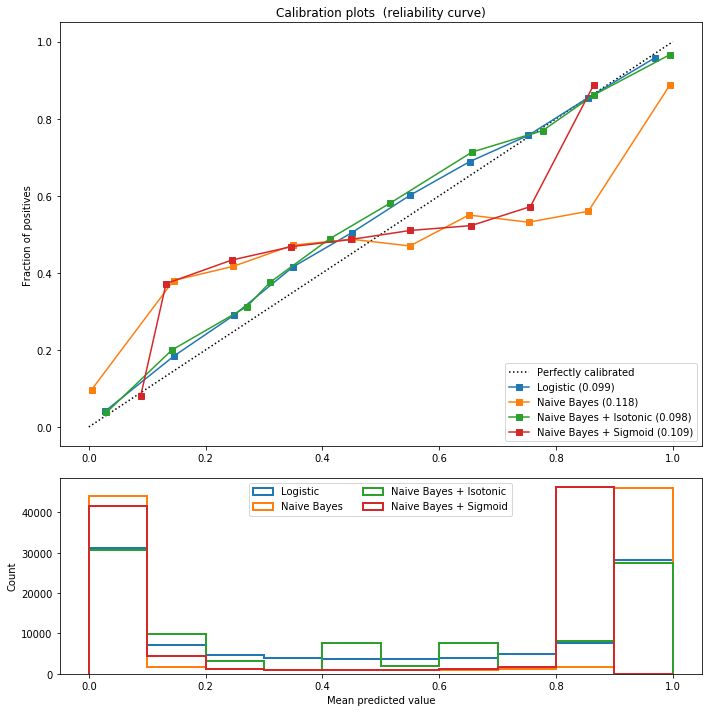

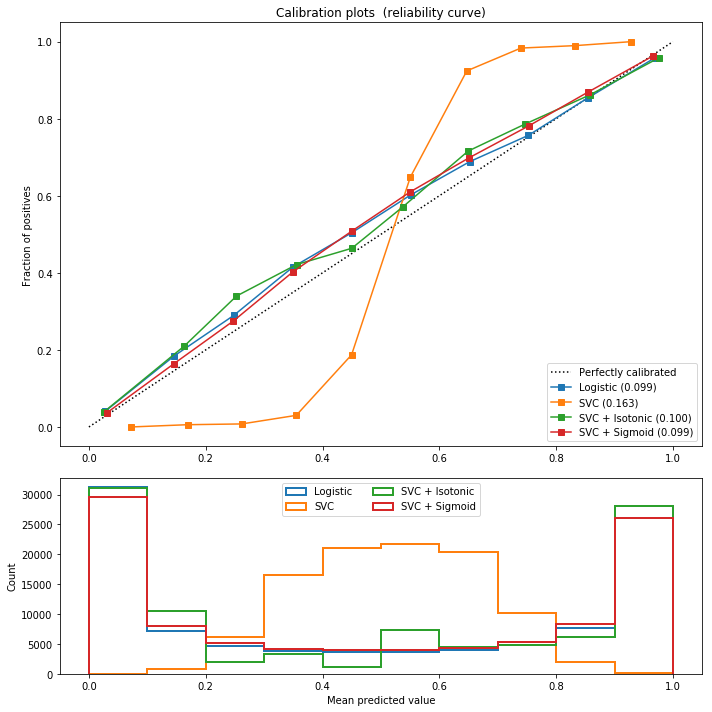

In [1]:
%matplotlib inline

#print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()